In [1]:
import cassiopeia as cas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
import networkx as nx
import pickle as pic
import numpy as np
import scipy

from collections import defaultdict

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

import figure_utils as f_utils

import os
import sys
cwd = os.getcwd()
sys.path.append("/".join(cwd.split("/")[:-1]) + "/scripts")
import utils as utils

In [2]:
folder_prefix = "../data/TLS/"

# Fig 3b

In [23]:
dag_res = []
tree_res = []

for i in range(11):
    df = pd.read_table(f"{folder_prefix}results/DAG/no_normalization_{i}_results.txt", header = 0)
    dag_res.append(df["objective_score"][0])

for i in range(5):
    df = pd.read_table(f"{folder_prefix}results/tree/no_normalization_{i}_results.txt", header = 0)
    tree_res.append(df["objective_score"][0])

In [24]:
# use number of cells that contribute to discrepancy

num_cells = 1864
tree_discrepancy = [d/num_cells for d in tree_res] + [min([d/num_cells for d in tree_res])] * (11 - len(tree_res))

df_data_DAG = pd.DataFrame({'k': range(1,12), 'discrepancy': [d/num_cells for d in dag_res]})
df_data_tree = pd.DataFrame({'k': range(1,12), 'discrepancy': tree_discrepancy})

In [11]:
discrepancy_df = pd.read_csv("TLS_method_discrepancies.txt", index_col = 0)

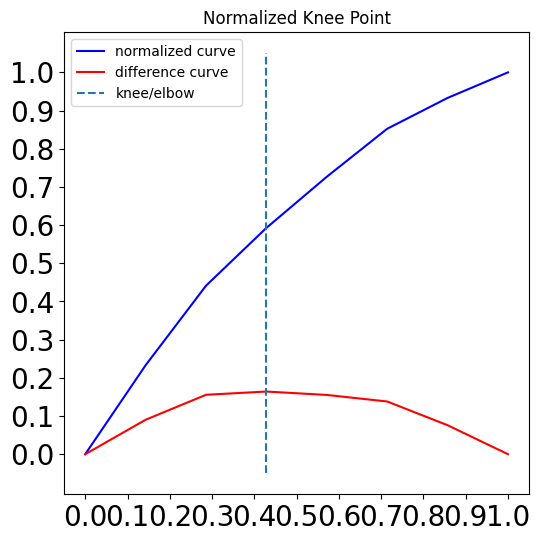

In [21]:
x, y = list(range(4, 12)), [d for d in dag_res][3:]
kneedle = KneeLocator(x, y, S = 1, curve = "convex", direction = "decreasing")
carta_k = kneedle.knee
kneedle.plot_knee_normalized()

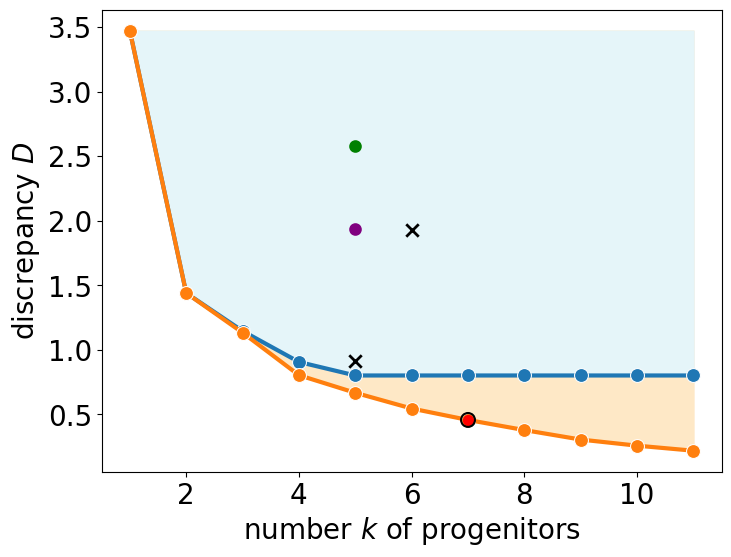

In [22]:
plt.fill_between(range(1, 12), [d/num_cells for d in dag_res], max([d/num_cells for d in dag_res]), color='#FEE8C6')
plt.fill_between(range(1, 12), tree_discrepancy, max([d/num_cells for d in dag_res]), color='#e5f5f9')
sns.lineplot(df_data_tree, x='k', y='discrepancy', linewidth=3, marker='o', markersize=10)
sns.lineplot(df_data_DAG, x='k', y='discrepancy', linewidth=3, marker='o', markersize=10)

# plt.axvline(5, 0, 1, linestyle = "--", zorder = 1)
# plt.text(5 + 0.1, 0 + 0.25, s = "Binary Tree")

for i, row in discrepancy_df.iterrows():
#     plt.text(row[2] + 0.25, row[1]/num_cells - 0.05, s = row[0])
    if row.iloc[0] == "ICE-FASE":
        plt.scatter(row.iloc[2], row.iloc[1]/num_cells, marker='o', linewidth=2.0, s = 50, c = 'purple')
    elif row.iloc[0] == "EvoC":
        plt.scatter(row.iloc[2], row.iloc[1]/num_cells, marker='o', linewidth=2.0, s = 50, c = 'green')
    else:
        plt.scatter(row.iloc[2], row.iloc[1]/num_cells, marker='x', linewidth=2.0, s = 80, c = 'black')

plt.scatter(carta_k, dag_res[carta_k - 1]/num_cells, marker='o', linewidth=1.5, s = 100, facecolors='none', color = 'black', zorder = 5)
plt.scatter(carta_k, dag_res[carta_k - 1]/num_cells, marker='o', s = 50, color = 'red', zorder = 4)
# plt.text(5 + 0.25, tree_res[4]/num_cells - 0.12, s = "Carta Tree")
# plt.scatter(5, tree_res[4]/num_cells, marker='o', linewidth=1.5, s = 100, facecolors='none', color = 'black', zorder = 5)
# plt.text(carta_k + 0.25, dag_res[carta_k - 1]/num_cells + 0.05, s = "Carta DAG")

plt.gcf().set_size_inches((8,6))
plt.gca().set_xlabel(r'number $k$ of progenitors', fontsize=20)
plt.gca().set_ylabel(r'discrepancy $D$', fontsize=20)
# plt.savefig("final_TLS_overview_panel.png", dpi = 300)
plt.show()

# Fig 3d

In [49]:
prefix = f"{folder_prefix}TLS_DAG_no_normalization_6"
file_locations_ = f"{folder_prefix}TLS_input_files.tsv"
states_file = f"{folder_prefix}TLS_states.txt"
node_labels_file = f"{folder_prefix}results/DAG/no_normalization_6_node_labels.txt"
edge_weight_scheme = "weighted_by_subtree_size"

In [50]:
states = []
with open(states_file, "r") as f:
    for line in f:
        states.append(line.rstrip())

node_labels_df = pd.read_table(node_labels_file)

line_ind = 0
labeled_trees = []
with open(file_locations_) as file_locations:
    for line in file_locations:
        nw, metadata = line.rstrip().split("\t")
        nw = folder_prefix + nw
        metadata = folder_prefix + metadata
        tree = cas.data.CassiopeiaTree(tree = nw)
        utils.label_tree_with_leaf_states(tree, metadata)
        utils.prune_unwanted_states(tree, states)
        utils.impute_states_from_children(tree)

        for index, row in node_labels_df[node_labels_df["tree_index"] == line_ind].iterrows():
            states_at_node = row["label"][1:-1].replace(" ", "").replace("'", "").split(",")
            tree.set_attribute(row["node_name"], "state_labels", states_at_node)

        labeled_trees.append(tree)
        line_ind += 1

if edge_weight_scheme == "raw_frequency":
    transition_counts = utils.get_transition_frequencies_over_trees(labeled_trees, states)
elif edge_weight_scheme == "weighted_by_subtree_size":
    transition_counts = utils.get_transition_frequencies_weighted_by_subtree_size(labeled_trees, states)

G = utils.generate_hasse_diagram(states)
G = utils.annotate_hasse_with_transitions(G, states, transition_counts, remove_zero_weight_edges=True)

In [51]:
trans_reduc = nx.transitive_reduction(G)
for e1, e2 in G.edges:
    G[e1][e2]["edge_density"] = G[e1][e2]["weight"] * 4
    if (e1, e2) in list(trans_reduc.edges):
        G[e1][e2]["direct"] = 1
    else:
        G[e1][e2]["direct"] = 0

In [52]:
flow_prop_thres = 0.2

to_remove = []

for v in G.nodes:
    out_degree = G.out_degree(v, weight = "weight")
    for e1, e2 in G.out_edges(v):
        if G[e1][e2]["weight"]/out_degree < flow_prop_thres and G[e1][e2]["direct"] != 1:
            to_remove.append((e1, e2))

for e1, e2 in to_remove:
    G.remove_edge(e1, e2)

for e1, e2 in G.edges:
    G[e1][e2]["weight"] = int(G[e1][e2]["weight"])

pic.dump(G, open(f"{prefix}_annotated_cell_fate_map.pkl", "wb"))

with open(f"{prefix}_annotated_cell_fate_map.cyjs", "w") as f:
    out = str(nx.cytoscape_data(G)).replace('\'', '\"').replace("True", "true").replace("False", "false")
    f.write(out)

13


# Fig 3f,g,h

In [76]:
state_order = [ "NMPs", "NeuralTube", "Somite", "Endoderm", "Endothelial", "PCGLC"]

index_map = {'Endoderm': "D",
             'NeuralTube': "N",
             'Somite': "S",
             'NMPs': "M",
             'Endothelial': "T",
             'PCGLC': "P"}

In [78]:
mats = []
progens_list = []

#CARTA k = 7
progens = [{'Endoderm', 'NeuralTube', 'Somite', 'NMPs', 'Endothelial', 'PCGLC'},
{'NeuralTube', 'NMPs', 'Somite'},
{'NeuralTube', 'PCGLC', 'Somite', 'Endothelial'},
{'NeuralTube', 'Somite'},
{'NeuralTube', 'NMPs'},
{'Somite', 'Endothelial'},
{'NeuralTube', 'Endoderm', 'Somite'}]

trans_mat, prog_columns = f_utils.make_heatmap_from_progens(folder_prefix, progens, state_order, index_map)
progens_list.append(prog_columns)
mats.append(trans_mat)

#ICE-FASE
progens = [
    tuple(sorted(('NeuralTube', 'Somite', 'Endothelial', 'NMPs', 'PCGLC', 'Endoderm'))),
    tuple(sorted(('NeuralTube', 'Somite', 'Endothelial', 'NMPs', 'Endoderm'))),
    tuple(sorted(('Endothelial', 'Endoderm', 'Somite'))),
    tuple(sorted(('NMPs', 'NeuralTube'))),
    tuple(sorted(('Somite', 'Endothelial'))),
]

trans_mat, prog_columns = f_utils.make_heatmap_from_progens(folder_prefix, progens, state_order, index_map)
progens_list.append(prog_columns)
mats.append(trans_mat)

# Evo-Coupling
progens = [
    tuple(sorted(('NeuralTube', 'Somite', 'Endothelial', 'NMPs', 'PCGLC', 'Endoderm'))),
    tuple(sorted(('Endothelial', 'NMPs'))),
    tuple(sorted(('Endoderm', 'NeuralTube', 'PCGLC', 'Somite'))),
    tuple(sorted(('Endoderm', 'PCGLC', 'Somite'))),
    tuple(sorted(('Endoderm', 'PCGLC'))),
]

trans_mat, prog_columns = f_utils.make_heatmap_from_progens(folder_prefix, progens, state_order, index_map)
progens_list.append(prog_columns)
mats.append(trans_mat)

#PhyloVelo
progens = [
    tuple(sorted(('NeuralTube', 'Somite', 'Endothelial', 'NMPs', 'PCGLC', 'Endoderm'))),
    tuple(sorted(('Endothelial', 'Somite'))),
    tuple(sorted(('PCGLC', 'Somite', 'NeuralTube', 'Endoderm'))),
    tuple(sorted(('PCGLC', 'Endoderm'))),
    tuple(sorted(('NMPs', 'Endoderm'))),
    tuple(sorted(('NMPs', 'NeuralTube'))),
]
trans_mat, prog_columns = f_utils.make_heatmap_from_progens(folder_prefix, progens, state_order, index_map)
progens_list.append(prog_columns)
mats.append(trans_mat)

#Fitch
progens = [
    tuple(sorted(('NeuralTube', 'Somite', 'Endothelial', 'NMPs', 'PCGLC', 'Endoderm'))),
    tuple(sorted(('NeuralTube', 'Somite', 'NMPs'))),
    tuple(sorted(('NeuralTube', 'Somite', 'NMPs', 'Endothelial'))),
    tuple(sorted(('NeuralTube', 'Somite', 'Endoderm'))),
    tuple(sorted(('Endoderm', 'PCGLC', 'Somite', 'NeuralTube'))),
]
trans_mat, prog_columns = f_utils.make_heatmap_from_progens(folder_prefix, progens, state_order, index_map)
progens_list.append(prog_columns)
mats.append(trans_mat)

In [79]:
for mat in mats:
    cols = list(mat.columns)
    cols[0] = "All"
    mat.columns = cols

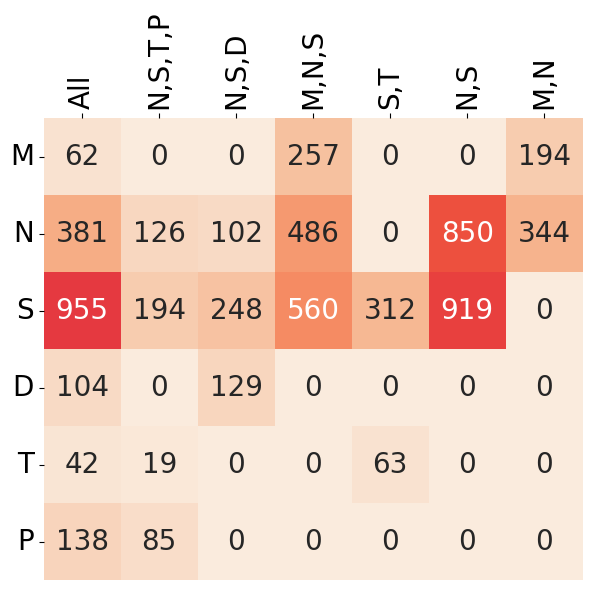

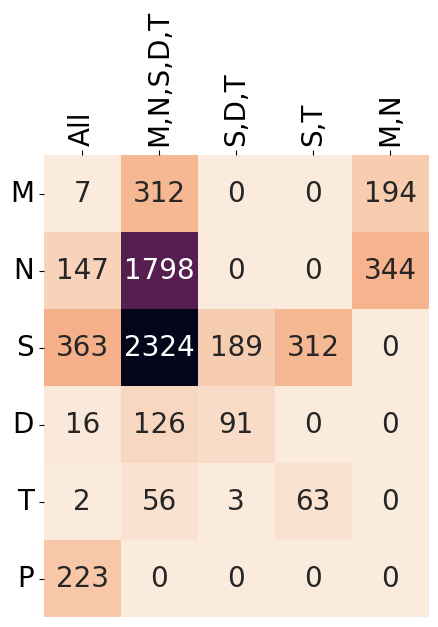

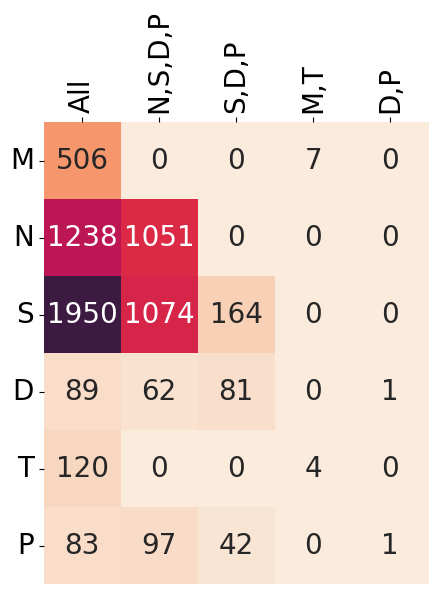

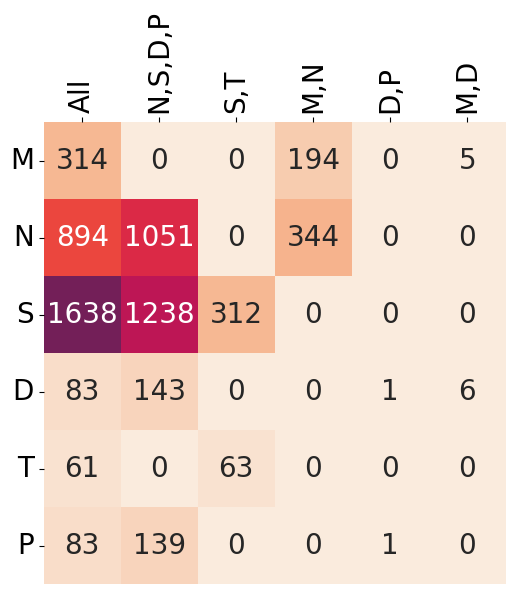

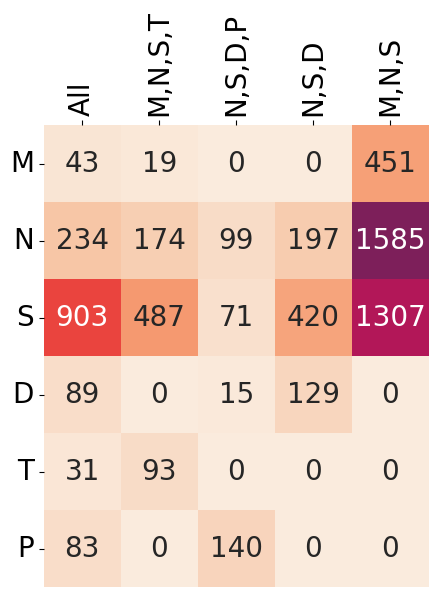

In [80]:
max_val = 0
for m in mats:
    max_val = max(max_val, np.nanmax(m.values))
ind_count = 0
for trans_mat in mats:
    plt.gcf().set_size_inches((trans_mat.shape[1], trans_mat.shape[0]))
    g = sns.heatmap(trans_mat, cmap = sns.cm.rocket_r, square=True, vmax = max_val, annot = True, fmt='g', cbar = False, annot_kws={'size': 20})
    plt.tick_params(labelbottom = False, bottom=False, top = True, labeltop=True, labelrotation = 90)
    plt.yticks(rotation = 0)
    g.set_facecolor('lightgrey')
    # plt.savefig(f"TLS_heatmap_{ind_count}.png", dpi = 300, bbox_inches="tight")
    plt.show()
    ind_count += 1

1.7590963749455082


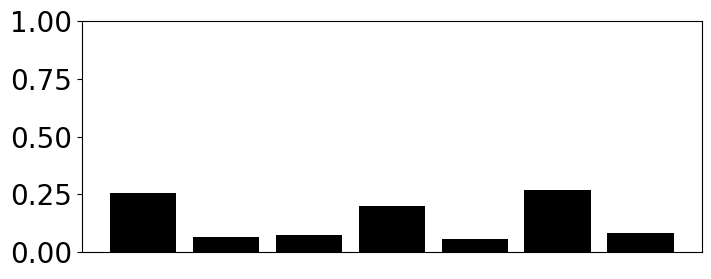

1.0009712877265393


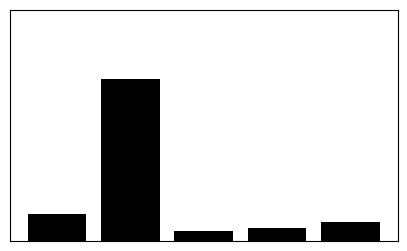

0.8204252442005416


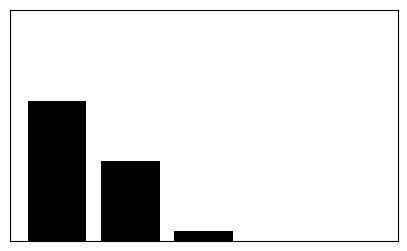

1.1040745947700674


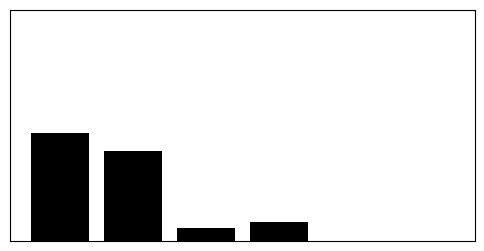

1.3193327145894633


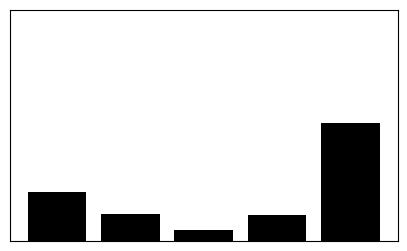

In [86]:
ind_count = 0
for mat, progens in zip(mats, progens_list):
    col_sums = np.sum(mat, axis = 0)/sum(sum(mat.values))
    
    plt.bar(col_sums.index, col_sums.values, color = "black")
    # print(sum(col_sums.values))
    plt.ylim(0, 1)
    # plt.xticks(rotation = 90)
    if ind_count == 0:
        plt.gcf().set_size_inches((mat.shape[1] + 1, 3))
        plt.tick_params(labelbottom = False, bottom=False)
    else:
        plt.gcf().set_size_inches((mat.shape[1], 3))
        plt.tick_params(labelbottom = False, bottom=False, left=False, labelleft=False)
    print(scipy.stats.entropy(col_sums.values))
    # plt.savefig(f"TLS_proportion_used_{ind_count}.png", dpi = 300, bbox_inches="tight")
    plt.show()
    ind_count += 1

1.4440661628571267
1306


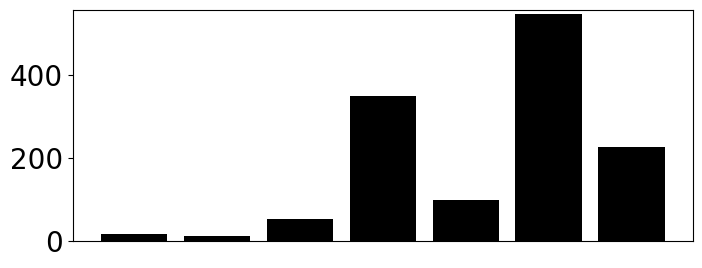

1.0909783474587151
382


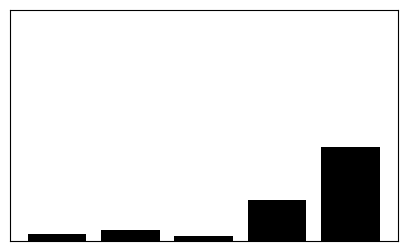

1.3706826472622562
41


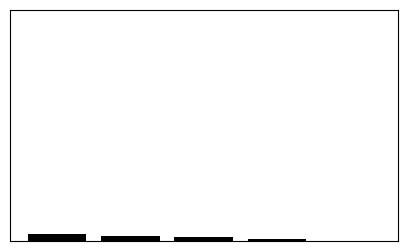

0.967309226767165
360


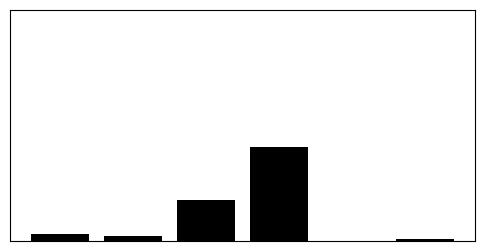

0.8355388017267633
459


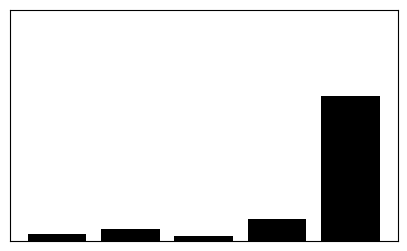

In [89]:
TLS_trees, states = f_utils.gen_trees(folder_prefix)
support = 0

support_vals = defaultdict(int)
for tree in TLS_trees:
    for n in tree.internal_nodes:
        leaf_set = set(
            [
                tree.get_attribute(l, "state_labels")[0]
                for l in tree.leaves_in_subtree(n)
            ]
        )
        out = sorted(list(leaf_set), key = lambda x: state_order.index(x))
        support_vals[(",".join([index_map[ct] for ct in out]))] += 1

ind_count = 0

for mat in mats:
    supports = {}
    for key in mat.columns:
        if key == "All":
            key = 'M,N,S,D,T,P'
        supports[key] = support_vals[key]
    plt.gcf().set_size_inches((mat.shape[1], 3))
    plt.bar(supports.keys(), supports.values(), color = "black")
    plt.ylim(0, max([support_vals[v] for v in support_vals.keys() if len(v) > 1]) + 10)
    plt.xticks(rotation = 90)
    print(scipy.stats.entropy(list(supports.values())))
    print(sum(list(supports.values())))
    if ind_count == 0:
        plt.gcf().set_size_inches((mat.shape[1] + 1, 3))
        plt.tick_params(labelbottom = False, bottom=False)
    else:
        plt.gcf().set_size_inches((mat.shape[1], 3))
        plt.tick_params(labelbottom = False, bottom=False, left=False, labelleft=False)
    # plt.savefig(f"TLS_support_{ind_count}.png", dpi = 300, bbox_inches="tight")
    plt.show()
    ind_count += 1

# Fig S2a,b and S3a

In [3]:
def process_tree(tree):
    meta = pd.read_csv("concat_TLS_meta.txt", sep = "\t")
    meta.index = meta["cellBC"]
    
    labeling = dict(zip(meta['cellBC'], meta['cell_state'])) # map from cell name -> cell state
    prune_states = ["aPSM", "pPSM", "Unknown"]
    prune_leaves = [u for u in tree.leaves if labeling[u] in prune_states]
    tree.remove_leaves_and_prune_lineages(prune_leaves)
    states = set(meta['cell_state']) - set(prune_states)
    
    utils.label_tree_with_leaf_states(tree, meta)

In [4]:
experiment_labels_df = pd.read_table(f"{folder_prefix}multiseq_barcodes.txt")
experiment_labels_dict = dict(zip(experiment_labels_df["ID"], experiment_labels_df["TLS ID"]))

newicks = []

with open(f"{folder_prefix}input_trees/AM-DNA-097_hybrid_newick_noMutationlessEdges_Labeled.nwk", "r") as f:
    newicks.append(f.readline())
with open(f"{folder_prefix}input_trees/AM-DNA-098_hybrid_newick_noMutationlessEdges_Labeled.nwk", "r") as f:
    newicks.append(f.readline())

for i in range(1, 25):
    if i == 17:
        continue
    if "CL" not in experiment_labels_dict[f"Bar{i}"]:
        with open(f'{folder_prefix}input_trees/Bar{i}_newick_noMutationlessEdges_Labeled.nwk', "r") as f:
            newicks.append(f.readline())

tot_leaves = 0
edited_newicks = []
for i in range(len(newicks)):
    n = newicks[i]
    tree = cas.data.CassiopeiaTree(tree = n)
    tot_leaves += len(tree.leaves)
    tree.relabel_nodes(dict(zip(tree.nodes, [c + f"_{i}" for c in tree.nodes])))
    edited_newicks.append(tree.get_newick())

complete_newick = ""
for n in edited_newicks:
    complete_newick += "" + n.split(";")[0][1:-1] + ","
complete_newick = complete_newick[:-1]
complete_newick = "(" + complete_newick
complete_newick += ");"

tree = cas.data.CassiopeiaTree(tree = complete_newick)

with open("concat_TLS.nwk", "w") as f:
    f.write(complete_newick)

dfs = []
ind_counter = 0

df = pd.read_table(f'{folder_prefix}formatted_and_reduced_labels/AM-DNA-097_metadata.txt')
df["cellBC"] = [c + f"_{ind_counter}" for c in df["cellBC"]]
dfs.append(df)
ind_counter += 1

df = pd.read_table(f'{folder_prefix}formatted_and_reduced_labels/AM-DNA-098_metadata.txt')
df["cellBC"] = [c + f"_{ind_counter}" for c in df["cellBC"]]
dfs.append(df)
ind_counter += 1

for i in range(1, 25):
    if i == 17:
        continue
    if "CL" not in experiment_labels_dict[f"Bar{i}"]:
        df = pd.read_table(f'{folder_prefix}formatted_and_reduced_labels/Bar{i}_metadata.txt')
        df["cellBC"] = [c + f"_{ind_counter}" for c in df["cellBC"]]
        dfs.append(df)
        ind_counter += 1

concat_df = pd.concat(dfs)

concat_df.to_csv("concat_TLS_meta.txt", sep = "\t", index = False)

In [5]:
tree = cas.data.CassiopeiaTree(tree = "concat_TLS.nwk")
meta = pd.read_csv("concat_TLS_meta.txt", sep = "\t")
meta.index = meta["cellBC"]

labeling = dict(zip(meta['cellBC'], meta['cell_state'])) # map from cell name -> cell state
prune_states = ["aPSM", "pPSM", "Unknown"]
prune_leaves = [u for u in tree.leaves if labeling[u] in prune_states]
tree.remove_leaves_and_prune_lineages(prune_leaves)
states = set(meta['cell_state']) - set(prune_states)

states_to_cells = defaultdict(list)
for _, row in meta.iterrows():
    if row[2] not in prune_states:
        states_to_cells[row[2]].append(row[1])

cells_to_sample = []
for s in states:
    cells_to_sample.extend(states_to_cells[s])

/tmp/ipykernel_1934520/1371716077.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[2] not in prune_states:
/tmp/ipykernel_1934520/1371716077.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  states_to_cells[row[2]].append(row[1])


In [6]:
percent_list = [i * 10 for i in range(2, 10)]

for percent in percent_list:
    for i in range(5):
        chosen_cells = np.random.choice(cells_to_sample, int(percent/100 * len(cells_to_sample)), replace = False)
        tree = cas.data.CassiopeiaTree(tree = "concat_TLS.nwk")
        tree.remove_leaves_and_prune_lineages(list(set(tree.leaves) - set(chosen_cells)))
    
        if not os.path.exists(f"{folder_prefix}results/TLS_bootstrap/random_undersample/{percent}_percent"):
            os.makedirs(f"{folder_prefix}results/TLS_bootstrap/random_undersample/{percent}_percent")
            os.makedirs(f"{folder_prefix}results/TLS_bootstrap/random_undersample/{percent}_percent/trees")
    
        # with open(f"{folder_prefix}results/TLS_bootstrap/random_undersample/{percent}_percent/trees/tree_{i}.nwk", "w") as f:
            # f.write(tree.get_newick(record_branch_lengths = False))
    
        # meta.loc[list(chosen_cells)].to_csv(f"{folder_prefix}results/TLS_bootstrap/random_undersample/{percent}_percent/trees/meta_{i}.txt",sep = "\t", index = False)

In [7]:
stability_jac_data = []

for k in range(5, 11):

    k_ = k - 1
    f = f"{folder_prefix}results/DAG/no_normalization_{k - 1}_progenitors.txt"
    g_progens = set([frozenset(i) for i in utils.get_progens_from_ilp_output(f) if len(i) > 1])
    
    for percent in [i * 10 for i in range(2, 10)]:
        for iter in range(5):
            res_progens = utils.get_progens_from_ilp_output(f"{folder_prefix}results/TLS_bootstrap/random_undersample/{percent}_percent/results/TLS_{iter}_progenitors_{k}.txt")
            res_progens = set([frozenset(i) for i in res_progens if len(i) > 1])

            jac_dist = 1 - len(g_progens.intersection(res_progens)) / len(g_progens.union(res_progens))
            
            stability_jac_data.append([k, percent/100, iter, jac_dist])
df_stability_jac = pd.DataFrame(stability_jac_data, columns = ['nprogs', 'prob', 'iter', 'jac'])

/tmp/ipykernel_1934520/2460192541.py:2: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.lineplot(data = df_stability_jac, x = 'prob', y='jac', hue= 'nprogs', palette=sns.color_palette())


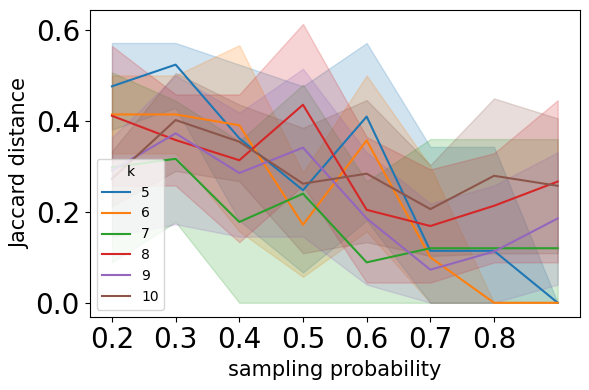

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data = df_stability_jac, x = 'prob', y='jac', hue= 'nprogs', palette=sns.color_palette())

plt.gca().set_xlabel(r'sampling probability', fontsize=15)
plt.gca().set_ylabel('Jaccard distance', fontsize=15);

plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
# plt.gca().set_xticklabels(['25 X 25', '50 X 50', '100 X 100'], fontsize=20)
# plt.gca().set_xticklabels(['25 X 25', '50 X 50'], fontsize=20)
plt.legend(title=r'k', loc='lower left')
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_stability_jaccard.pdf', bbox_inches='tight')

In [13]:
states = ['Endoderm', 'NMPs', 'PCGLC', 'Endothelial', 'Somite', 'NeuralTube']

stability_hamming_data = []

for k in range(5, 11):

    gt_node_labels = {}

    tree = cas.data.CassiopeiaTree(tree = "concat_TLS.nwk")
    process_tree(tree)
    f = f"{folder_prefix}results/DAG/no_normalization_{k - 1}_progenitors.txt"
    f_utils.annotate_trees_from_progens([tree], states, [set(p) for p in utils.get_progens_from_ilp_output(f)])
    for n in tree.internal_nodes:
        if len(set(tree.get_attribute(n, "state_labels"))) > 1:
            gt_node_labels[n] = set(tree.get_attribute(n, "state_labels"))
    
    for percent in [i * 10 for i in range(2, 10)]:
        for iter in range(5):

            res_node_labels = {}

            tree = cas.data.CassiopeiaTree(tree = "concat_TLS.nwk")
            process_tree(tree)
            f_ = f"{folder_prefix}results/TLS_bootstrap/random_undersample/{percent}_percent/results/TLS_{iter}_progenitors_{k}.txt"
            f_utils.annotate_trees_from_progens([tree], states, [set(p) for p in utils.get_progens_from_ilp_output(f_)])
            for n in gt_node_labels:
                res_node_labels[n] = set(tree.get_attribute(n, "state_labels"))

            hamming_dist = 0
            for n in gt_node_labels:
                s1 = gt_node_labels[n]
                s2 = res_node_labels[n]
                hamming_dist += len(s1 - s2) + len(s2 - s1)

            hamming_dist = hamming_dist/(len(gt_node_labels) * len(states))
            
            stability_hamming_data.append([k, percent/100, iter, hamming_dist])
df_stability_ham = pd.DataFrame(stability_hamming_data, columns = ['nprogs', 'prob', 'iter', 'ham'])

/tmp/ipykernel_1934520/2825720708.py:2: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.lineplot(data = df_stability_ham, x = 'prob', y='ham', hue= 'nprogs', palette=sns.color_palette())


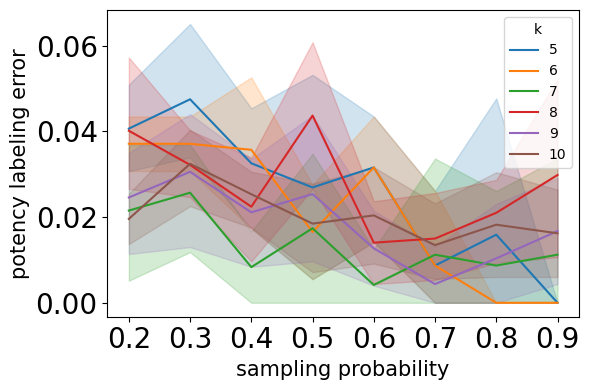

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.lineplot(data = df_stability_ham, x = 'prob', y='ham', hue= 'nprogs', palette=sns.color_palette())

plt.gca().set_xlabel(r'sampling probability', fontsize=15)
plt.gca().set_ylabel('potency labeling error', fontsize=15);

plt.xticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# plt.gca().set_xticklabels(['25 X 25', '50 X 50', '100 X 100'], fontsize=20)
# plt.gca().set_xticklabels(['25 X 25', '50 X 50'], fontsize=20)
plt.legend(title=r'k', loc='upper right')
plt.tight_layout()
fig.patch.set_facecolor('white')
# plt.savefig('figures/larry_stability_potency.pdf', bbox_inches='tight')

In [ ]:
percent_list_ = [20, 40, 60, 80]

for percent in percent_list:
    if not os.path.exists(f"{folder_prefix}results/TLS_bootstrap/subsample_one_state/trees/{percent}"):
        os.makedirs(f"{folder_prefix}results/TLS_bootstrap/subsample_one_state/trees/{percent}")
    
    for s in states:
        if not os.path.exists(f"{folder_prefix}results/TLS_bootstrap/subsample_one_state/trees/{percent}/{s}"):
            os.makedirs(f"{folder_prefix}results/TLS_bootstrap/subsample_one_state/trees/{percent}/{s}")
        
        for i in range(6, 11):
            dropped_cells = np.random.choice(states_to_cells[s], int(percent/100 * len(states_to_cells[s])), replace = False)
            tree = cas.data.CassiopeiaTree(tree = "concat_TLS.nwk")
            tree.remove_leaves_and_prune_lineages(list(dropped_cells) + prune_leaves)
        
            with open(f"{folder_prefix}results/TLS_bootstrap/subsample_one_state/trees/{percent}/{s}/tree_{i}.nwk", "w") as f:
                # f.write(tree.get_newick(record_branch_lengths = False))
        
            remaining_cells = list(set(cells_to_sample) - set(dropped_cells))
            # meta.loc[remaining_cells].to_csv(f"/n/fs/ragr-data/users/palash/carta-rebuttal/results/TLS_bootstrap/subsample_one_state/trees/{percent}/{s}/meta_{i}.txt",sep = "\t", index = False)

In [22]:
## drop s% of one cell type at a time

drop_one_jac_data = []

f = f"{folder_prefix}results/DAG/no_normalization_6_progenitors.txt"
g_progens = utils.get_progens_from_ilp_output(f)
g_progens = set([frozenset(i) for i in g_progens if len(i) > 1])

for percent in percent_list_:
    for s in states:
        for i in list(range(5)) + list(range(6, 11)):
            f = f"/n/fs/ragr-data/users/palash/carta-rebuttal/results/TLS_bootstrap/subsample_one_state/results/{percent}/{s}/TLS_{i}_progenitors_7.txt"
            res_progens = utils.get_progens_from_ilp_output(f)
            res_progens = set([frozenset(p) for p in res_progens if len(p) > 1])
            
            jac_dist = 1 - len(g_progens.intersection(res_progens)) / len(g_progens.union(res_progens))
            drop_one_jac_data.append([100 - percent, s, i, jac_dist])
    
            # print(g_progens.intersection(res_progens))
            # print(i, "missed: ", g_progens - res_progens, jac_dist)
            # print(i, "added: ", res_progens - g_progens, jac_dist)

<Axes: xlabel='sampling_p', ylabel='state'>

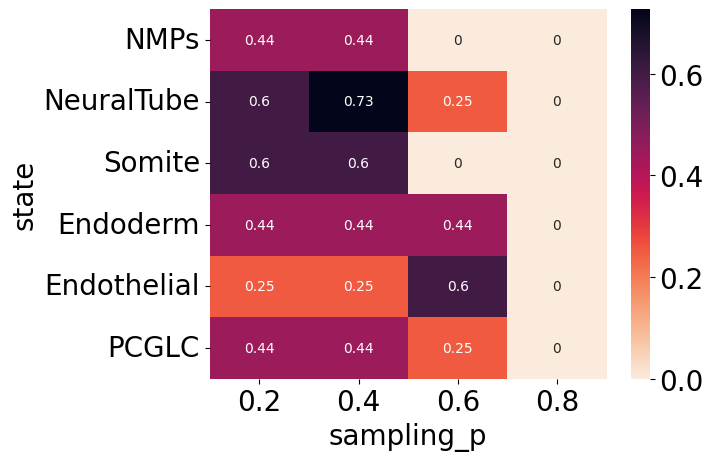

In [23]:
drop_one_df = pd.DataFrame(drop_one_jac_data, columns = ["sampling_p", "state", "index", "jac"])
drop_one_df["sampling_p"] = drop_one_df["sampling_p"]/100
piv = pd.pivot_table(drop_one_df, values = "jac", index = "sampling_p", columns = "state", aggfunc = "median").T
sns.heatmap(piv.loc[["NMPs", "NeuralTube", "Somite", "Endoderm", "Endothelial", "PCGLC"], :], cmap="rocket_r", annot = True)